<a
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab9.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

 Deep Reinforcement Learning

## Objective

- Build DQN and PPO Deep RL algorithms
- Show the difference between Q Learning and Policy Gradient techniques



### TODO

- Train DQN and PPO on cartpole
- Display learning curves with average episodic reward per epoch

## Init

In [ ]:
! pip3 install gymnasium
! pip3 install torch
! pip install pygame
! pip install moviepy==1.0.3
! pip install imageio_ffmpeg
! pip install pyvirtualdisplay
! apt-get install -y xvfb python3-opengl ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np

from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(40) #error only

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400,900))
display.start()

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

def wrap_env(env):
  env = RecordVideo(env, './video')
  return env

## DQN

## Part 1


$Loss=\frac{1}{N}\sum \bigg(Q(s,a) - (r + \gamma \underset{a'\sim A}{max} \hat{Q}(s',a')(1-d))\bigg)^2 $

### TODO

- Implement get action method with e-greedy policy
- Implement sample batch method
- Implement DQN learning algorithm



In [ ]:
def get_action_dqn(network, state, epsilon, epsilon_decay):
  """Select action according to e-greedy policy and decay epsilon

    Args:
        network (QNetwork): Q-Network
        state (np-array): current state, size (state_size)
        epsilon (float): probability of choosing a random action
        epsilon_decay (float): amount by which to decay epsilon

    Returns:
        action (int): chosen action [0, action_size)
        epsilon (float): decayed epsilon
  """


  state = torch.FloatTensor(state).cuda()
  q_vals = network(state.unsqueeze(0))

  if random.random() > epsilon:
      action = torch.argmax(q_vals).item()
  else:
      action = random.randint(0, q_vals.size(1) - 1)

  epsilon *= epsilon_decay
  return action, epsilon


def prepare_batch(memory, batch_size):
  """Randomly sample batch from memory
     Prepare cuda tensors

    Args:
        memory (list): state, action, next_state, reward, done tuples
        batch_size (int): amount of memory to sample into a batch

    Returns:
        state (tensor): float cuda tensor of size (batch_size x state_size)
        action (tensor): long tensor of size (batch_size)
        next_state (tensor): float cuda tensor of size (batch_size x state_size)
        reward (tensor): float cuda tensor of size (batch_size)
        done (tensor): float cuda tensor of size (batch_size)
  """
  state, action, next_state, reward, done = zip(*random.sample(memory, batch_size))

  state = torch.FloatTensor(state).cuda()
  action = torch.LongTensor(action).cuda()
  next_state = torch.FloatTensor(next_state).cuda()
  reward = torch.FloatTensor(reward).cuda()
  done = torch.FloatTensor(done).cuda()

  return state, action, next_state, reward, done

def learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update):
  """Update Q-Network according to DQN Loss function
     Update Target Network every target_update global steps

    Args:
        batch (tuple): tuple of state, action, next_state, reward, and done tensors
        optim (Adam): Q-Network optimizer
        q_network (QNetwork): Q-Network
        target_network (QNetwork): Target Q-Network
        gamma (float): discount factor
        global_step (int): total steps taken in environment
        target_update (int): frequency of target network update
  """
  state, action, next_state, reward, done = batch

  q_vals = q_network(state).gather(1, action[:,None]).squeeze()
  next_q_vals = torch.max(target_network(next_state), dim=1)[0]
  target_q_vals = reward + (gamma * next_q_vals * (1 - done))

  loss = torch.mean((q_vals-target_q_vals)**2)

  optim.zero_grad()
  loss.backward()
  optim.step()

  if global_step % target_update == 0:
        target_network.load_state_dict(q_network.state_dict())


### Modules

In [ ]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8

    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size))

  def forward(self, x):
    """Estimate q-values given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          q-values (tensor): estimated q-values, size (batch x action_size)
    """
    return self.net(x)

### Main

In [ ]:
def dqn_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 500
  start_training = 1000
  gamma = 0.99
  batch_size = 32
  epsilon = 1
  epsilon_decay = .9999
  target_update = 1000
  learn_frequency = 2

  # Init environment
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1', render_mode="rgb_array")

  # Init networks
  q_network = QNetwork(state_size, action_size).cuda()
  target_network = QNetwork(state_size, action_size).cuda()
  target_network.load_state_dict(q_network.state_dict())

  # Init optimizer
  optim = torch.optim.Adam(q_network.parameters(), lr=lr)

  # Init replay buffer
  memory = []

  # Begin main loop
  results_dqn = []
  global_step = 0
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    last_epoch = (epoch+1 == epochs)
    # Record the last epoch, not the previous epochs
    if last_epoch:
      env = wrap_env(env)

    # Reset environment
    state, _ = env.reset()
    done = False
    cum_reward = 0  # Track cumulative reward per episode

    # Begin episode
    while not done and cum_reward < 200:  # End after 200 steps
      # Select e-greedy action
      action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay)

      # Take step
      next_state, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      # env.render()

      # Store step in replay buffer
      memory.append((state, action, next_state, reward, done))

      cum_reward += reward
      global_step += 1  # Increment total steps
      state = next_state  # Set current state

      # If time to train
      if global_step > start_training and global_step % learn_frequency == 0:

        # Sample batch
        batch = prepare_batch(memory, batch_size)

        # Train
        learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)
    env.close()
    # Print results at end of episode
    results_dqn.append(cum_reward)
    loop.update(1)
    loop.set_description('Episodes: {} Reward: {}'.format(epoch, cum_reward))

  return results_dqn

results_dqn = dqn_main()
show_video()

Episodes: 498 Reward: 200.0: 100%|█████████▉| 499/500 [01:56<00:00,  2.61it/s]

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4




t:  93%|█████████▎| 188/202 [00:00<00:00, 204.77it/s, now=None]
                                                                              

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


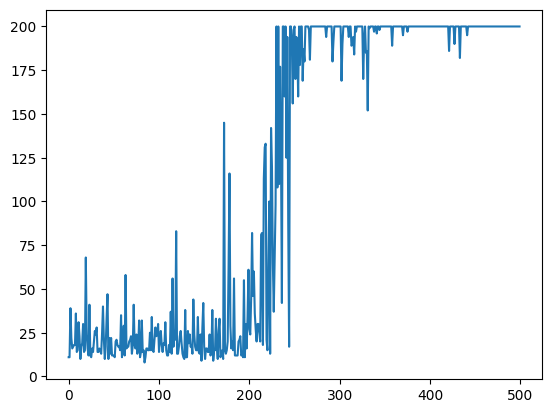

In [ ]:
plt.plot(results_dqn)
plt.show()

## PPO

## Part 2

Proximal Policy Optimization

$Loss=ValueLoss+PolicyLoss$

$ValueLoss=\frac{1}{N}\sum \bigg(\hat{R} - V(s) \bigg)^2 $

$PolicyLoss=-\frac{1}{N}\sum \min\bigg( \frac{\pi'(a|s)}{\pi(a|s)} \hat{A}, clip(\frac{\pi'(a|s)}{\pi(a|s)},1-\epsilon,1+\epsilon) \hat{A} \bigg) $

$\hat{R}_t = \sum_{i=t}^H \gamma^{i-t}r_i$

$\hat{A}_t=\hat{R}_t-V(s_t)$


### TODO

- Implement calculate return method
- Implement get action method
- Implement PPO learning algorithm

In [ ]:
def calculate_return(memory, rollout, gamma):
  """Return memory with calculated return in experience tuple

    Args:
        memory (list): (state, action, action_dist, return) tuples
        rollout (list): (state, action, action_dist, reward) tuples from last rollout
        gamma (float): discount factor

    Returns:
        list: memory updated with (state, action, action_dist, return) tuples from rollout
  """
  the_return = 0
  for i in reversed(range(len(rollout))):
      state, action, action_dist, reward = rollout[i]
      the_return = reward + (gamma*the_return)
      memory.append((state, action, action_dist, the_return))

  return memory


def get_action_ppo(network, state):
  """Sample action from the distribution obtained from the policy network
    Args:
        network (PolicyNetwork): Policy Network
        state (np-array): current state, size (state_size)

    Returns:
        int: action sampled from output distribution of policy network
        array: output distribution of policy network
  """
  curr_state = torch.cuda.FloatTensor(state).unsqueeze(0)
  output_dist = network(curr_state)
  action = torch.multinomial(output_dist,1).item()

  out_det = output_dist.detach()
  return action, out_det


def learn_ppo(optim, policy, value, memory_dataloader, epsilon, policy_epochs):
  """Implement PPO policy and value network updates. Iterate over your entire
     memory the number of times indicated by policy_epochs.

    Args:
        optim (Adam): value and policy optimizer
        policy (PolicyNetwork): Policy Network
        value (ValueNetwork): Value Network
        memory_dataloader (DataLoader): dataloader with (state, action, action_dist, return) tensors
        epsilon (float): trust region
        policy_epochs (int): number of times to iterate over all memory
  """

  for epoch in range(policy_epochs):
    for state, action, action_dist, the_return in memory_dataloader:

      action = torch.LongTensor(action).cuda()
      action_dist = torch.cuda.FloatTensor(action_dist).squeeze()
      state = torch.FloatTensor(state).cuda()
      the_return = the_return.type_as(torch.cuda.FloatTensor())

      adv = the_return - value(state).squeeze()

      new_action_probs = policy(state)
      ratio = new_action_probs.gather(1, action.unsqueeze(1)) / action_dist.unsqueeze(1)
      s1 = ratio * adv.unsqueeze(1)
      s2 = torch.clamp(ratio, 1-epsilon, 1+epsilon) * adv.unsqueeze(1)

      loss = F.mse_loss(value(state).squeeze(), the_return) - torch.min(s1,s2).mean()

      optim.zero_grad()
      loss.backward()
      optim.step()



### Modules

In [ ]:
# Dataset that wraps memory for a dataloader
class RLDataset(Dataset):
  def __init__(self, data):
    super().__init__()
    self.data = []
    for d in data:
      self.data.append(d)

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return len(self.data)


# Policy Network
class PolicyNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8

    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size),
                             nn.Softmax(dim=1))

  def forward(self, x):
    """Get policy from state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          action_dist (tensor): probability distribution over actions (batch x action_size)
    """
    return self.net(x)


# Value Network
class ValueNetwork(nn.Module):
  def __init__(self, state_size):
    super().__init__()
    hidden_size = 8

    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, 1))

  def forward(self, x):
    """Estimate value given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          value (tensor): estimated value, size (batch)
    """
    return self.net(x)

### Main

In [ ]:
def ppo_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 20
  env_samples = 100
  gamma = 0.9
  batch_size = 256
  epsilon = 0.2
  policy_epochs = 5

  # Init environment
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1', render_mode="rgb_array")

  # Init networks
  policy_network = PolicyNetwork(state_size, action_size).cuda()
  value_network = ValueNetwork(state_size).cuda()

  # Init optimizer
  optim = torch.optim.Adam(chain(policy_network.parameters(), value_network.parameters()), lr=lr)

  # Start main loop
  results_ppo = []
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    last_epoch = (epoch+1 == epochs)
    # Record only last epoch
    if last_epoch:
      env = wrap_env(env)

    memory = []  # Reset memory every epoch
    rewards = []  # Calculate average episodic reward per epoch

    # Begin experience loop
    for episode in range(env_samples):

      # Reset environment
      state, _ = env.reset()
      done = False
      rollout = []
      cum_reward = 0  # Track cumulative reward

      # Begin episode
      while not done and cum_reward < 200:  # End after 200 steps
        # Get action
        action, action_dist = get_action_ppo(policy_network, state)

        # Take step
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        # env.render()

        # Store step
        rollout.append((state, action, action_dist, reward))

        cum_reward += reward
        state = next_state  # Set current state

      # Calculate returns and add episode to memory
      memory = calculate_return(memory, rollout, gamma)

      rewards.append(cum_reward)
      env.close()
    # Train
    dataset = RLDataset(memory)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    learn_ppo(optim, policy_network, value_network, loader, epsilon, policy_epochs)

    # Print results
    results_ppo.extend(rewards)  # Store rewards for this epoch
    loop.update(1)
    loop.set_description("Epochs: {} Reward: {}".format(epoch, results_ppo[-1]))

  return results_ppo

results_ppo = ppo_main()
show_video()

Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:46<00:03,  3.10s/it]

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4




Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:47<00:03,  3.10s/it]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:47<00:03,  3.10s/it]

Moviepy - Building video /content/video/rl-video-episode-1.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1.mp4




Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:47<00:03,  3.10s/it]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1.mp4


Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:47<00:03,  3.10s/it]

Moviepy - Building video /content/video/rl-video-episode-8.mp4.
Moviepy - Writing video /content/video/rl-video-episode-8.mp4




Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:47<00:03,  3.10s/it]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-8.mp4


Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:48<00:03,  3.10s/it]

Moviepy - Building video /content/video/rl-video-episode-8.mp4.
Moviepy - Writing video /content/video/rl-video-episode-8.mp4




Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:48<00:03,  3.10s/it]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-8.mp4


Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:49<00:03,  3.10s/it]

Moviepy - Building video /content/video/rl-video-episode-27.mp4.
Moviepy - Writing video /content/video/rl-video-episode-27.mp4




Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:49<00:03,  3.10s/it]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-27.mp4


Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:49<00:03,  3.10s/it]

Moviepy - Building video /content/video/rl-video-episode-27.mp4.
Moviepy - Writing video /content/video/rl-video-episode-27.mp4




Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:49<00:03,  3.10s/it]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-27.mp4


Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:50<00:03,  3.10s/it]

Moviepy - Building video /content/video/rl-video-episode-64.mp4.
Moviepy - Writing video /content/video/rl-video-episode-64.mp4




Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:50<00:03,  3.10s/it]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-64.mp4


Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:51<00:03,  3.10s/it]

Moviepy - Building video /content/video/rl-video-episode-64.mp4.
Moviepy - Writing video /content/video/rl-video-episode-64.mp4




Epochs: 18 Reward: 12.0:  95%|█████████▌| 19/20 [00:51<00:03,  3.10s/it]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-64.mp4


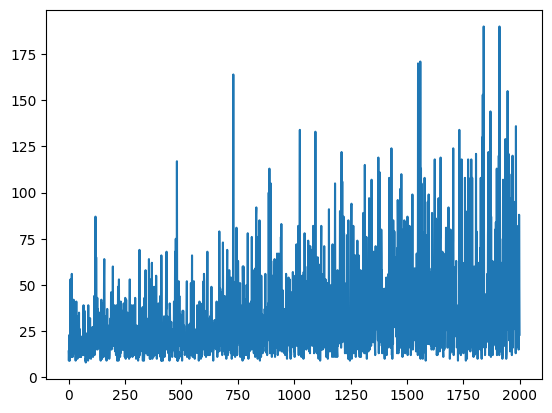

In [ ]:
plt.plot(results_ppo)
plt.show()